# Data Ingestion & Pre-Processing
This notebook ingests both the train and test datasets for the Ames Housing project in order to fit and score a Linear Regression model. Housing prices are then predicted using the test data and written to a .csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv('./datasets/train.csv')

In [3]:
test_data = pd.read_csv('./datasets/test.csv')

---

# Feature Engineering
Write functions that programmatically map common rating scales (Excellent, Good, Average, Fair, Poor) to numerical values.

In [4]:
def qual_cond_scale(obj):
    if obj == 'Ex':
        return 5
    elif obj == 'Gd':
        return 4
    elif obj == 'TA':
        return 3
    elif obj == 'Fa':
        return 2
    elif obj == 'Po':
        return 1
    else:
        return 0

In [5]:
# BsmtFin Type 1 & Garage Finish column
def finish_scale(obj):
    if obj == 'GLQ':
        return 6
    elif obj == 'ALQ':
        return 5
    elif obj == 'BLQ':
        return 4
    elif obj == 'Rec' or obj == 'Fin':
        return 3
    elif obj == 'LwQ'or obj == 'RFn':
        return 2
    elif obj == 'Unf' or obj == 'Unf':
        return 1
    else:
        return 0

In [6]:
# Encode categorical variables in Functional column
def func_scale(obj):
    if obj == 'Typ':
        return 7
    elif obj == 'Min1':
        return 6
    elif obj == 'Min2':
        return 5
    elif obj == 'Mod':
        return 4
    elif obj == 'Maj1':
        return 3
    elif obj == 'Maj2':
        return 2
    elif obj == 'Sev':
        return 1
    elif obj == 'Sal':
        return 0
    else:
        return np.nan

In [7]:
# Create a custom feature that combines several quality & condition variables
def merge_loc(df, col_list):
    location_sum = []
    for col in col_list:
        location_sum.append(df[col] / df[col].mean())
        
    return round(sum(location_sum), 4)

In [8]:
# Condense categorical location variables to either "Near Road", "Near Rail",  or "Near Amenity"
def location_vars(obj):
    if obj == 'RRNn' or obj == 'RRAn' or obj == 'RRNe' or obj == 'RRAe':
        return 'near_rail'
    elif obj == 'Artery' or obj == 'Feedr':
        return 'near_road'
    elif obj == 'PosN' or obj == 'PosA':
        return 'near_amenity'
    else:
        return None

In [9]:
# Create a dictionary to map nominal values in Neighborhoods to ordinal values
neighborhoods = {'StoneBr':28, 'NridgHt':27, 'NoRidge':26, 'Veenker':25, 'Somerst':24, 'Timber':23, 'ClearCr':22, 'CollgCr':21,
'Crawfor':20, 'NWAmes':19, 'SawyerW':18, 'Gilbert':17, 'Blmngtn':16, 'Mitchel':15, 'NAmes':14, "Sawyer":13,
'SWISU':12, 'Edwards':11, 'BrkSide':10, 'OldTown':9, 'IDOTRR':8, 'GrnHill':7, 'Greens':6, 'Blueste':5,
'NPkVill':4, 'MeadowV':3, 'BrDale':2, 'Landmrk':1}

In [10]:
# Create a dictionary to map nominal values in Garage Type to ordinal values
garages = {'BuiltIn':6, 'Attchd':5, '2Types':4, 'Basment':3, 'Detchd':2, 'CarPort':1}

In [11]:
# Create a dictionary to map nominal values in Zoning to more readable categories
zones = {'RL':'res_lo_dens', 'RM':'res_md_dens', 'FV':'res_float_vil', "C (all)":'commercial',
           'RH':'res_hi_dens', "A (agr)":'agricultural', "I (all)":'industrial'}

---
# Pre-Process Raw Data
Write a reproducible function to pre-process the housing data into machine-learning ready format.

In [12]:
def process_dataset(df):
    
    ### ENCODING CATEGORICAL VARIABLES ###
    
    # Encode categorical ratings to numeric scales
    qual_cond_transform = [
        'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Heating QC', 'Kitchen Qual',
        'Fireplace Qu', 'Garage Qual', 'Garage Cond'] 

    for col in qual_cond_transform:
        df[col] = df[col].apply(qual_cond_scale)
    
    df['Neighborhood'] = df['Neighborhood'].apply(lambda x: neighborhoods[x] if x in neighborhoods else 0)
    df['Garage Type'] = df['Garage Type'].apply(lambda x: garages[x] if x in garages else 3.5)
    df['MS Zoning'] = df['MS Zoning'].apply(lambda x: zones[x] if x in zones else None)
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].apply(finish_scale)
    df['Garage Finish'] = df['Garage Finish'].apply(finish_scale)
    df['Functional'] = df['Functional'].apply(func_scale)
    df['Condition 1'] = df['Condition 1'].apply(location_vars)
    df['Condition 2'] = df['Condition 2'].apply(location_vars)
    
    # One-hot encode cateogrical features as dummy columns
    bldg_types = pd.get_dummies(df['Bldg Type'], prefix = 'is')
    year_sold = pd.get_dummies(df['Yr Sold'], prefix='sold')
    zone_type = pd.get_dummies(df['MS Zoning'])
    cond1 = pd.get_dummies(df['Condition 1'], prefix='cond1')
    cond2 = pd.get_dummies(df['Condition 2'], prefix='cond2')
    
    # Concatenate dummy columns to original DataFrame
    df = pd.concat([df, bldg_types, year_sold, zone_type], axis = 1)
    
    
    ### FEATURE ENGINEERING ###
     
    # Interaction feature that combines several quality & condition variables
    df['Loc Score'] = merge_loc(df, df[['Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Functional']])
    
    # Interaction feature that combines square footage from multiple levels of a building
    df['Total SF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
    
    # Combination of Residential Zoning dummy columns
    df['residential'] = ((4*zone_type['res_float_vil']) + (3*zone_type['res_lo_dens']) +
                    (2*zone_type['res_md_dens']) + (1*zone_type['res_hi_dens']))
    
    # Create new column if property has been remodeled in the last 10 years
    #df['Recent Remod'] = ((2010 - df['Year Remod/Add'])>10)*1
    
    # Subtract Year Built from year of data collection to get age of home
    #df['Year Built'] = 2010 - df['Year Built']
    
    # Add columns if property is near Road, Rail, or an Amenity
    df['near_amenity'] = cond1['cond1_near_amenity'] + cond2['cond2_near_amenity']
    if 'cond2_near_rail'in cond2.columns:
        df['near_rail'] = cond1['cond1_near_rail'] + cond2['cond2_near_rail']
    else:
        df['near_rail'] = cond1['cond1_near_rail']
    df['near_road'] = cond1['cond1_near_road'] + cond2['cond2_near_road']
    
    ### HANDLE STATISTICAL OUTLIERS ###
    
    # Drop outliers in General Living Area & Bedroom columns
    df.drop(list(df[df['Gr Liv Area'] > 5_000].index), axis=0)
    df.drop(list(df[df['Bedroom AbvGr'] > 6].index), axis=0)
    
    # Replace outliers in Kitchen & Total SqFt. column
    df['Kitchen AbvGr'] = df['Kitchen AbvGr'].apply(lambda x: 2 if x >= 3 else (1 if x <= 0 else x))
    df['Total SF'] = df['Total SF'].apply(lambda x: 6_000 if x >= 6_000 else x)
    
    ### FINAL PRE-PROCESSING ###
    
    # Drop original categorical columns that were encoded above
    df.drop(columns=['Bldg Type', 'Yr Sold'], axis = 1, inplace = True)
    
    # List of unneccessary or irrelevant columns to drop
    cols_to_drop = ['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Condition 1', 'Condition 2', 'Lot Area',
                'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 
                'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
                'Foundation', 'Bsmt Exposure', 'BsmtFin Type 2', 'BsmtFin SF 2',
                'Heating', 'Central Air', 'Electrical', 'Low Qual Fin SF', 'Gr Liv Area',
                'Garage Yr Blt', 'Paved Drive', 'Enclosed Porch', '1st Flr SF', 'Total Bsmt SF',
                '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Pool QC', 'Misc Val', 'Sale Type', 
                'House Style', 'Bsmt Cond', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
                '2nd Flr SF', 'TotRms AbvGrd', 'Half Bath', 'Fireplace Qu', 'Garage Area', 'Kitchen AbvGr',
                'Fence', 'Misc Feature', 'Mo Sold', 'Lot Frontage', 'Functional', 'Year Remod/Add',
                'Exter Qual', 'Exter Cond', 'Overall Cond', 'Garage Finish', 'Garage Qual', 'Open Porch SF',
                'res_float_vil', 'res_lo_dens', 'res_md_dens', 'res_hi_dens']
    
    df = df.drop(cols_to_drop, axis = 1)
    
    extra_neighborhoods = ['in_GrnHill', 'in_Landmrk']
    
    if 'agricultural' in df.columns:
        df.drop(columns='agricultural', axis = 1, inplace = True)
    
    for loc in extra_neighborhoods:
        if loc in df.columns:
            df.drop(loc, axis = 1, inplace = True)
    
    # Take the log of the Sale Price
    if 'SalePrice' in df.columns:
        df['SalePrice'] = np.log(df['SalePrice'])
    
    # Fill any missing values with 0
    df = df.fillna(0)
    
    return df

---
# Train and Fit a Linear Regression Model
Using the function written above, pre-process the train and test datasets.

In [13]:
df_train = process_dataset(train_data)

In [14]:
Id = test_data['Id'] # Save test data Id column for Kaggle submission

In [15]:
df_test = process_dataset(test_data)

## Instantiate, Fit, and Score Model
Split the training data into X and y variables in order to fit and score a Linear Regression model.

In [16]:
X = df_train.drop(columns='SalePrice')
y = df_train['SalePrice']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Calculate metrics to score model on training data

In [18]:
def metrics(model, X, y):
    #Generate predictions using train testset
    y_preds = model.predict(X)
    
    r2 = model.score(X, y)
    rmse = mean_squared_error(np.exp(y), np.exp(y_preds), squared = False)
    
    return (f"r2={round(r2, 4)}, rmse={round(rmse, 4)}")

In [19]:
def baseline_mse(y):
    return round(mean_squared_error(np.exp(y), np.array([np.exp(y).mean()]*len(y)), squared = False), 4)

In [20]:
metrics(lr, X_train, y_train)

'r2=0.9084, rmse=23594.3642'

In [21]:
print(f"baseline rmse = {baseline_mse(y_train)}")

baseline rmse = 79577.726


In [22]:
cross_val_score(lr, X_train, y_train).mean()

0.9017270053395547

In [23]:
metrics(lr, X_test, y_test)

'r2=0.8244, rmse=36526.3748'

In [24]:
print(f"baseline rmse = {baseline_mse(y_test)}")

baseline rmse = 78194.5682


### Evaluate accuracy of model using variable coefficients

In [25]:
coefs_LR = pd.DataFrame(data=(list((zip(X.columns, np.exp(lr.coef_.ravel()))))))
coefs_LR.columns=['Variable', 'Coefficient']
coefs_LR.set_index('Variable', inplace = True)
avg_price = np.exp(df_train['SalePrice'].mean())
coefs_LR['Coefficient'] = (coefs_LR['Coefficient'] - 1) * avg_price

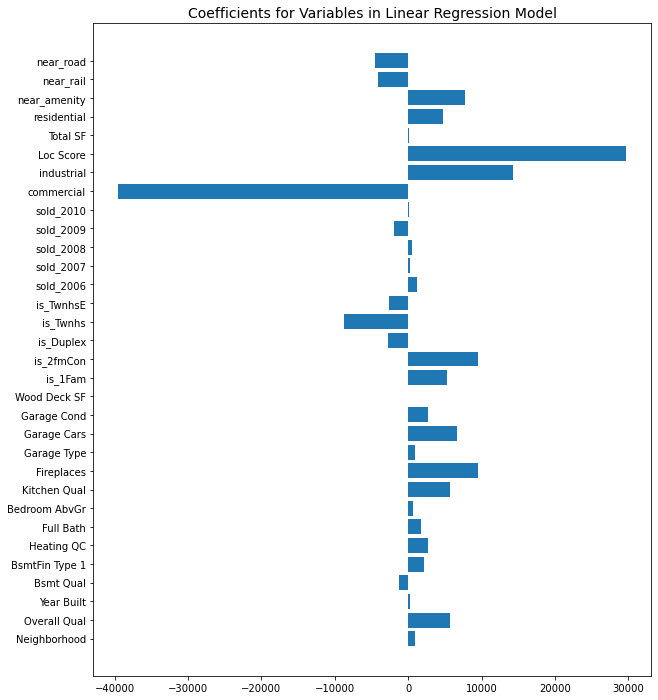

In [26]:
plt.figure(figsize=(10, 12))
plt.barh(y=list(coefs_LR.index), width=list(coefs_LR.values.ravel()));
plt.title("Coefficients for Variables in Linear Regression Model", fontsize=14);

In [27]:
coefs_LR.sort_values('Coefficient', ascending=False).head(10)

,Coefficient
Variable,
Loc Score,29621.201585
industrial,14306.025994
is_2fmCon,9560.780914
Fireplaces,9501.953419
near_amenity,7700.045958
Garage Cars,6592.863337
Overall Qual,5709.318297
Kitchen Qual,5700.581130
is_1Fam,5316.119866


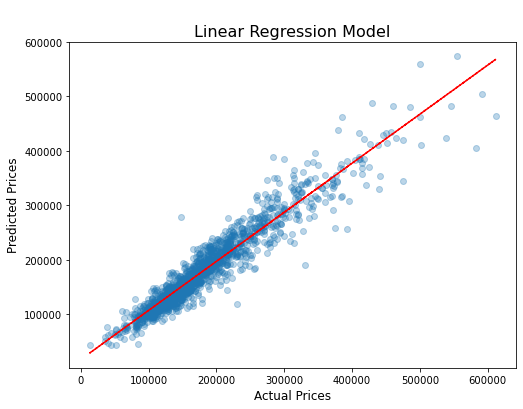

In [28]:
OLS_preds = lr.predict(X_train)

plt.figure(figsize=(8,6));
x_axis = np.exp(y_train)
y_axis = np.exp(OLS_preds)

plt.scatter(x=x_axis, y=y_axis, alpha=.3)
plt.title("\nLinear Regression Model", fontsize=16);
plt.xlabel('Actual Prices', fontsize=12);
plt.ylabel('Predicted Prices', fontsize=12);

trendline = np.polyfit(x_axis, y_axis, 1)
line = np.poly1d(trendline)
plt.plot(x_axis, line(x_axis), "r--", linestyle='--')

plt.show()

# Fit and Score a Ridge Regression

In [29]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [30]:
ridge = Ridge(alpha=18.48)
ridge.fit(Z_train, y_train)

Ridge(alpha=18.48)

Cross validate for the best alpha value of a Ridge Regression.

In [31]:
# Range of 50 numbers between -10 and 20
ridge_alphas = np.linspace(-10, 50, 100)

# Cross-validate over range of ridge alphas
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=10)

# Fit ridge model to optimal alpha value
ridge_cv.fit(Z_train, y_train)

ridge_cv.alpha_

18.484848484848484

In [32]:
metrics(ridge, Z_train, y_train)

'r2=0.9084, rmse=23629.6635'

In [33]:
cross_val_score(ridge, Z_train, y_train).mean()

0.9018733275798224

In [34]:
metrics(ridge, Z_test, y_test)

'r2=0.826, rmse=35830.0119'

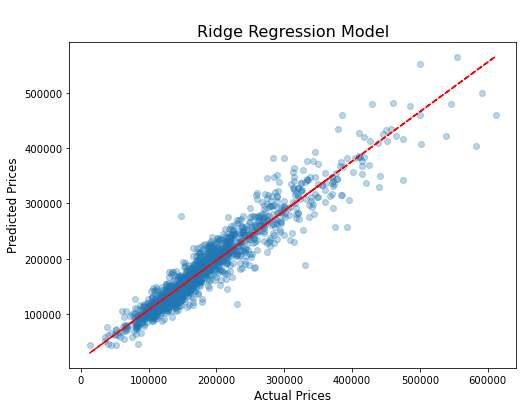

In [35]:
ridge_preds = ridge.predict(Z_train)

plt.figure(figsize=(8,6));
x2_axis = np.exp(y_train)
y2_axis = np.exp(ridge_preds)

plt.scatter(x=x2_axis, y=y2_axis, alpha=.3)
plt.title("\nRidge Regression Model", fontsize=16);
plt.xlabel('Actual Prices', fontsize=12);
plt.ylabel('Predicted Prices', fontsize=12);

trendline2 = np.polyfit(x2_axis, y2_axis, 1)
line2 = np.poly1d(trendline2)
plt.plot(x2_axis, line2(x2_axis), "r--", linestyle='--')

plt.show()

In [36]:
coefs_ridge = pd.DataFrame(data=(list((zip(X.columns, np.exp(ridge_cv.coef_.ravel()))))))
coefs_ridge.columns=['Variable', 'Coefficient']
coefs_ridge.set_index('Variable', inplace = True)
avg_price = np.exp(df_train['SalePrice'].mean())
coefs_ridge['Coefficient'] = (coefs_ridge['Coefficient'] - 1) * avg_price

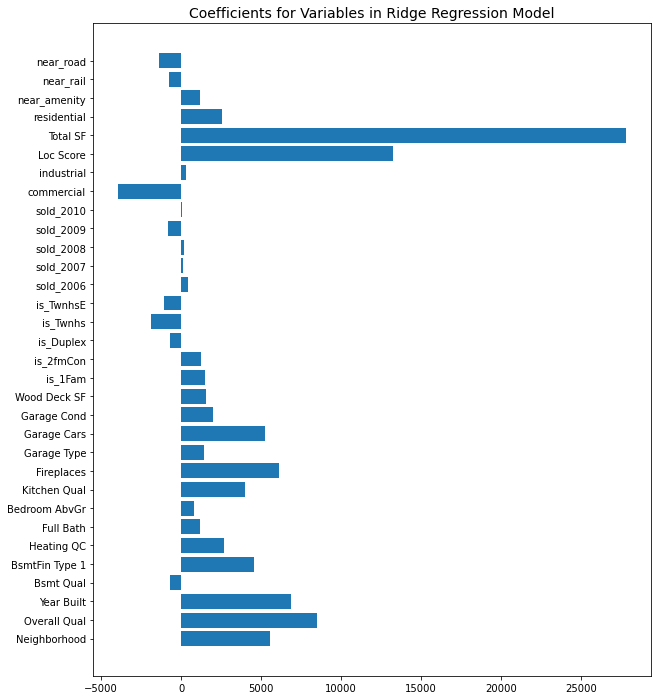

In [37]:
plt.figure(figsize=(10, 12))
plt.barh(y=list(coefs_ridge.index), width=list(coefs_ridge.values.ravel()));
plt.title("Coefficients for Variables in Ridge Regression Model", fontsize=14);

In [38]:
coefs_ridge.sort_values('Coefficient', ascending=False).head()

,Coefficient
Variable,
Total SF,27774.954900
Loc Score,13265.435304
Overall Qual,8515.922334
Year Built,6866.754658
Fireplaces,6102.026789


# Fit and Score a Lasso Regression

In [39]:
lasso = Lasso(.0001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [40]:
lasso_alphas = np.linspace(0.0001, 1, 50)

# Cross-validate over range of Lasso alphas
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=50000)

# Fit model using best ridge alpha
lasso_cv.fit(Z_train, y_train);

lasso_cv.alpha_

0.0001

In [41]:
metrics(lasso, X_train, y_train)

'r2=0.9084, rmse=23587.5755'

In [42]:
cross_val_score(lasso, X_train, y_train).mean()

0.9017607613410284

In [43]:
metrics(lasso, X_test, y_test)

'r2=0.8249, rmse=36522.0631'

In [44]:
coefs_lasso = pd.DataFrame(data=(list((zip(X.columns, np.exp(lasso.coef_.ravel()))))))
coefs_lasso.columns=['Variable', 'Coefficient']
coefs_lasso.set_index('Variable', inplace = True)
avg_price = np.exp(df_train['SalePrice'].mean())
coefs_lasso['Coefficient'] = (coefs_lasso['Coefficient'] - 1) * avg_price

In [45]:
coefs_lasso.sort_values('Coefficient', ascending=False)

,Coefficient
Variable,
Loc Score,29377.188831
is_2fmCon,11408.818038
Fireplaces,9449.657442
is_1Fam,7903.334236
near_amenity,7000.975485
Garage Cars,6562.400158
Overall Qual,5742.322777
Kitchen Qual,5680.400471
residential,4796.885828


This zeroed out a number of variables but had a slightly lower R2 score.

---
## Predict unseen housing prices using the test data

In [46]:
predicted_prices = ridge.predict(sc.transform(df_test))
df_kaggle_subs = pd.DataFrame(data = np.exp(predicted_prices))
df_kaggle_subs.set_index(Id, inplace = True) # set index to Id column in test dataset
df_kaggle_subs

,0
Id,
2658,135500.653617
2718,177337.380628
2414,198107.286173
1989,114356.503020
625,176920.625852
...,...
1662,200935.462118
1234,228022.749429
1373,134755.321112


In [47]:
# Save predicted y-values to csv
#df_kaggle_subs.to_csv('./datasets/submissions/ridge.csv', index = True, header = ['SalePrice'])